<img src='./img/LogoWekeo_Copernicus_RGB_0.png' align='right' width='20%'></img>

# Example data processing for crop mapping

In this tutorial we will use the WEkEO Jupyterhub to access and analyse data from the Copernicus Sentinel-2.
A region in northern Corsica has been selected as as a common test site across the land training as it contains representative landscape features and process elements which can be used to demonstrate the capabilities and strengths of Copernicus space component and services.
The tutorial comprises the following steps:
1. Search and download data: We will select and download a Sentinel-2 scene and the CLMS CORINE Land Cover (CLC) data from their original archive locations via WEkEO using the Harmonised Data Access (HAD) API.
2.	[Read and view Sentinel-2 data](#load_sentinel2): Once downloaded, we will read and view the Sentinel-2 data in geographic coordinates as true colour image and other formats.
3.	[Process and view Sentinel-2 data as a vegetation index](#sentinel2_ndvi): We will see how the vegetation density and health can be assessed from optical EO data to support crop and landscape management practices.

NOTE - This Jupyter Notebook contains a subset if the additonal processing added to demonstrate further functionality during the land training debrief.

<img src='./img/CropBanner.jpg' align='center' width='100%'></img>

## <a id='load_sentinel2'></a>2. Load required Sentinel-2 bands and True Color image at 10 m spatial resolution

Before we begin we must prepare our environment. This includes importing the various python libraries that we will need.

### Load required libraries

In [1]:
import os
import rasterio as rio
from rasterio import plot
from rasterio.mask import mask
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.plot import show
from rasterio.plot import plotting_extent
import zipfile
from matplotlib import rcParams
from pathlib import Path
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib import cm
from matplotlib import colors
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import HTML
from rasterio.warp import calculate_default_transform, reproject, Resampling

The Sentinel-2 Multiple Spectral Imager (MSI) records 13 spectral bands across the visible and infrared portions of the electromagnetic spectrum at different spatial resolutions from 10 m to 60 m depending on their operation and use. There are currently two Sentinel-2 satellites in suitably phased orbits to give a revisit period of 5 days at the Equator and 2-3 days at European latitudes. Being an optical sensor they are of course also affected by cloud cover and illumination conditions. The two satellites have been fully operational since 2017 and record continuously over land and the adjacent coastal sea areas. Their specification represents a continuation and upgrade of the US Landsat system which has archive data stretching back to the mid 1980s.

<img src='./img/S2_band_comp.png' align='center' width='50%'></img>

For this training session we will use the 20 m spatial resolution data as we wish to exploit one of the SWIR bands. The 20 m spatial resultion data can be sharpened to 10 m with additional processing. We therefore load a composite true colour image (made up of the blue, green and red bands) and the individual bands for green (600 nm), red (665 nm), near infrared (833 nm) and shortwave infrared (1612 nm). The cell below loads the required data.

In [2]:
#Download folder
download_dir_path = os.path.join(os.getcwd(), 'data/from_wekeo')
data_path = os.path.join(os.getcwd(), 'data')

R20 =  os.path.join(download_dir_path, 'S2A_MSIL2A_20170802T101031_N0205_R022_T32TNN_20170802T101051.SAFE/GRANULE/L2A_T32TNN_A011030_20170802T101051/IMG_DATA/R20m') #20 meters resolution folder
TCI =  rio.open(R20+'/L2A_T32TNN_20170802T101031_TCI_20m.jp2') #true color

### Display True Color to check the correct data is downloaded

The true colour image for the Sentinel-2 data downloaded in the previous JN can be displayed as a plot to show we have the required area and assess other aspects such as the presence of cloud, cloud shadow, etc. 

In this case we selected region of northern Corsica showing the area around Bastia and the Tyrrhenian Sea out to the Italian island of Elba in the east. The area has typical Mediterranean vegetation with mountainous semi natural habitats and urban and agricultural areas along the coasts.

The cell below displays the true colour image in its native WGS-84 coordinate reference system.

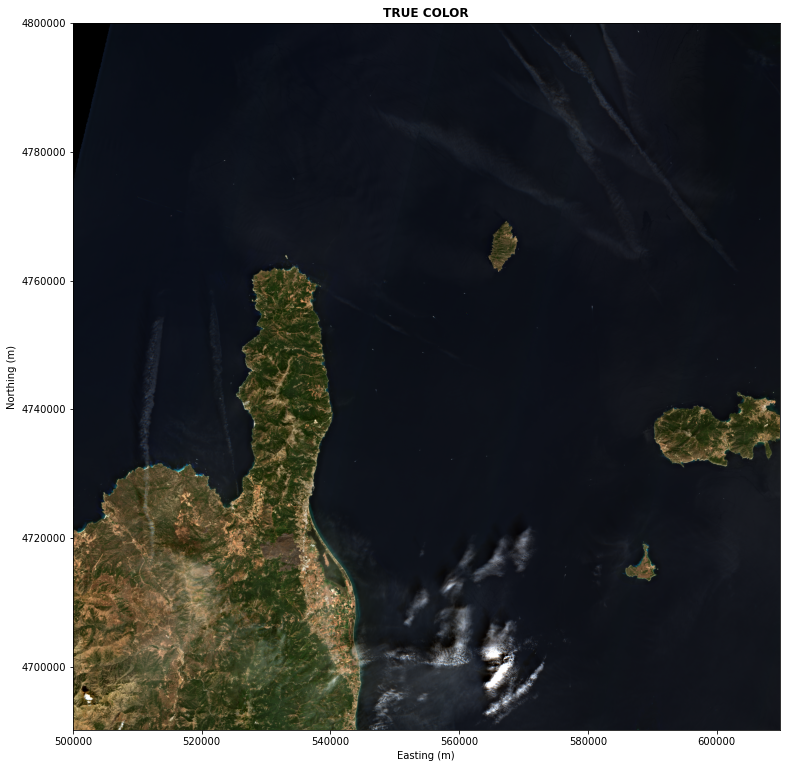

In [3]:
fig, (ax) = plt.subplots(1,1, figsize=(13,13))
show(TCI.read(), ax=ax, transform=TCI.transform,  title = "TRUE COLOR")
ax.set_ylabel("Northing (m)") # (WGS 84 / UTM zone 32N)
ax.set_xlabel("Easting (m)")
ax.ticklabel_format(axis = 'both', style = 'plain')

### Open Vector Data

In [4]:
path_shp  = os.path.join(os.getcwd(), 'shp')
crop = gpd.read_file(os.path.join(path_shp, 'CropMap-aoi.shp'))

### Check CRS of Vector Data

Before we can use the vector data we must check the coordinate reference system (CRS) and then transpose them to the same CRS as the Sentinel-2 data. In this case we require all the data to be in the WGS 84 / UTM zone 32N CRS with the EPSG code of 32632.

In [5]:
print(crop.crs)

epsg:32632


### Open and crop the required Sentinel-2 bands

The required Sentinel-2 bands are then cropped using the AOI geometry. 

In [6]:
with rio.open(R20+'/L2A_T32TNN_20170802T101031_TCI_20m.jp2') as src: # true colour
    out_image, out_transform = mask(src, crop.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform}) 
with rio.open(os.path.join(data_path, "S2_20m_TCI_masked.tif"), "w", **out_meta) as dest:
    dest.write(out_image)   
    
with rio.open(R20+'/L2A_T32TNN_20170802T101031_B03_20m.jp2') as src: # green
    out_image, out_transform = mask(src, crop.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rio.open(os.path.join(data_path, "S2_20m_B03_masked.tif"), "w", **out_meta) as dest:
    dest.write(out_image)   
    
with rio.open(R20+'/L2A_T32TNN_20170802T101031_B04_20m.jp2') as src: # red
    out_image, out_transform = mask(src, crop.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rio.open(os.path.join(data_path, "S2_20m_B04_masked.tif"), "w", **out_meta) as dest:
    dest.write(out_image)   
    
with rio.open(R20+'/L2A_T32TNN_20170802T101031_B8A_20m.jp2') as src: # near infrared
    out_image, out_transform = mask(src, crop.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rio.open(os.path.join(data_path, "S2_20m_B8A_masked.tif"), "w", **out_meta) as dest:
    dest.write(out_image)  
    
with rio.open(R20+'/L2A_T32TNN_20170802T101031_B11_20m.jp2') as src: # shortwave infrared
    out_image, out_transform = mask(src, crop.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rio.open(os.path.join(data_path, "S2_20m_B11_masked.tif"), "w", **out_meta) as dest:
    dest.write(out_image)  

### Display True Color, False Colour Infrared and Shortwave Infrared Composite images

The true colour image are one of the common formats for displaying optical EO data such as for the Sentinel-2. However, other formats show different characterisitics of the sufrace. The centre plot shows the same image in false colour infrared (FCIR) format. In this format the green band is displayed as blue, red as green and near infrared as red. Vegetated areas appear red and water is black. The right hand plot shows the same image as a shortwave infrared composite displaying near infrared as red, shortwave infrared as green and red as blue. 

The cell below displays the true colour image in its native WGS-84 coordinate reference system.

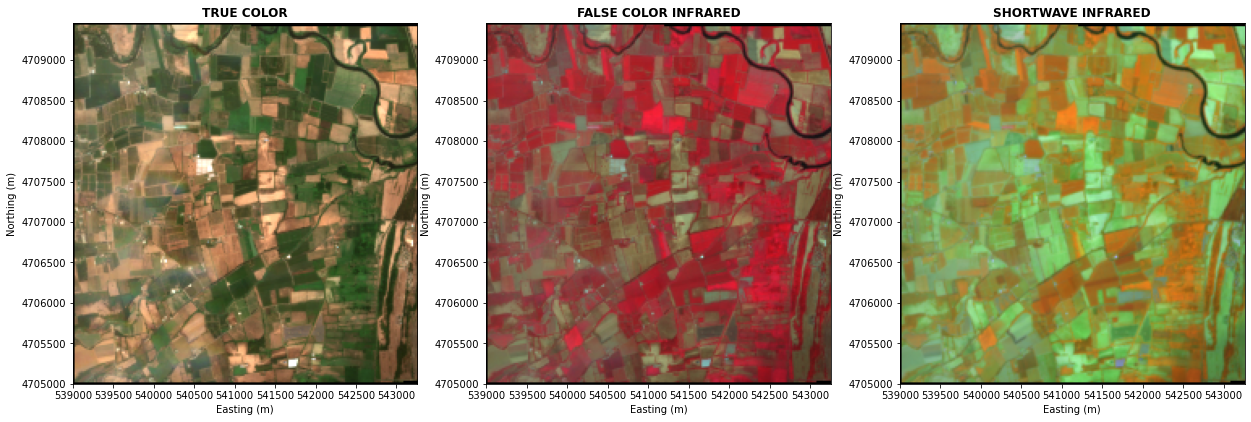

In [7]:
b3 = rio.open(os.path.join(data_path, "S2_20m_B03_masked.tif")) # green
b4 = rio.open(os.path.join(data_path, "S2_20m_B04_masked.tif")) # red
b8a = rio.open(os.path.join(data_path, "S2_20m_B8A_masked.tif")) # near infrared 
b11 = rio.open(os.path.join(data_path, "S2_20m_B11_masked.tif")) # shortwave infrared 
TCI = rio.open(os.path.join(data_path, "S2_20m_TCI_masked.tif")) # true color

fig, (ax, ay, az) = plt.subplots(1,3, figsize=(21,7))
show(TCI.read(), ax=ax, transform=TCI.transform,  title = "TRUE COLOR")
ax.set_ylabel("Northing (m)") # (WGS 84 / UTM zone 32N)
ax.set_xlabel("Easting (m)")
ax.ticklabel_format(axis = 'both', style = 'plain')

# Function to normalize false colour infrared image 
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max() 
    return ((array - array_min)/(array_max - array_min))

nir = b8a.read(1)
red = b4.read(1)
green = b3.read(1)
nirn = normalize(nir)
redn = normalize(red)
greenn = normalize(green)
FCIR = np.dstack((nirn, redn, greenn))
FCIR = np.moveaxis(FCIR.squeeze(),-1,0)
show(FCIR, ax=ay, transform=TCI.transform, title = "FALSE COLOR INFRARED")
ay.set_ylabel("Northing (m)") # (WGS 84 / UTM zone 32N)
ay.set_xlabel("Easting (m)")
ay.ticklabel_format(axis = 'both', style = 'plain')

sw = b11.read(1)
swn = normalize(sw)
SWIR = np.dstack((nirn, swn, redn))
SWIR = np.moveaxis(SWIR.squeeze(),-1,0)
show(SWIR, ax=az, transform=TCI.transform, title = "SHORTWAVE INFRARED")
az.set_ylabel("Northing (m)") # (WGS 84 / UTM zone 32N)
az.set_xlabel("Easting (m)")
az.ticklabel_format(axis = 'both', style = 'plain')

## <a id='sentinel2_ndvi'></a>3. Process and view Sentinel-2 data as a vegetation index

Vegetation status is a combination of a number of properties of the vegetation related to growth, density, health and environmental factors. By making measurements of surface reflectance in the red and near infrared (NIR) parts of the spectrum optical instruments can summarise crop status through a vegetation index. The red region is related to chlorophyll absorption and the NIR is related to multiple scattering within leaf structures, therefore low red and high NIR represent healthy / dense vegetation. These values are summarised in the commonly used Normalised Difference Vegetation Index (NDVI).

<img src='./img/ndvi.jpg' align='center' width='40%'></img>

### Calculate NDVI from red and near infrared bands

First step is to calculate the NDVI for the whole image using some straightforward band maths and write out the result to a geoTIFF file.

In [24]:
nir = b8a.read(1)
red = b4.read(1)

ndvi = (nir.astype(float)-red.astype(float))/(nir+red)
meta = b4.meta 
meta.update(driver='GTiff')
meta.update(dtype=rio.float64)
with rio.open(os.path.join(data_path, 'S2_NDVICrop_masked.tif'), 'w', **meta) as dst:
    dst.write(ndvi,1)

### Display NDVI 

The AOI represents an agricultural area of northern Corsica just to the south of the Airport of Bastia Poretta. These lowlands have been cleared for agriculture shown by a fine scale mosaic of regular geometric features representing crop fields with diffrerent NDVIs or the presence of vegetated boundary features. The lower values of NDVI (close to zero) are associated with bare fields, sealed surfaces and water.

The colour map used to display the NDVI uses a ramp from blue to green to emphasise the increasing density and vigour of vegetation at high NDVI values. If distinction are not so clear the cmap value can be change from "BuGn" or "RdBu" to something more appropriate with reference to the the available colour maps at [Choosing Colormaps in Matplotlib](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html).

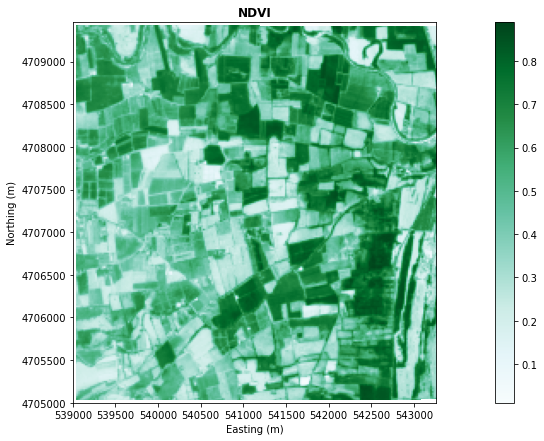

In [25]:
#S2_NDVI_masked
ndvi_aoi = rio.open(os.path.join(data_path, 'S2_NDVICrop_masked.tif'))

fig, (az) = plt.subplots(1,1, figsize=(21, 7))

# use imshow so that we have something to map the colorbar to
image_hidden_1 = az.imshow(ndvi_aoi.read(1), 
                         cmap='BuGn')

image = show(ndvi_aoi, ax=az, cmap='BuGn', transform=ndvi_aoi.transform, title ="NDVI")

fig.colorbar(image_hidden_1, ax=az)
az.set_ylabel("Northing (m)") #(WGS 84 / UTM zone 32N)
az.set_xlabel("Easting (m)")
az.ticklabel_format(axis = 'both', style = 'plain')

### Histogram of NDVI values

If the NDVI values for the area are summarised as a histogram with a broad range of vegetation density / vigour apprent. On the left of the plot there are the water and unvegetated areas together due to their low NDVI and then moving to the right the broad peak from an NDVI value of 0.3 to 0.8 related to different levels of crop vigour. 

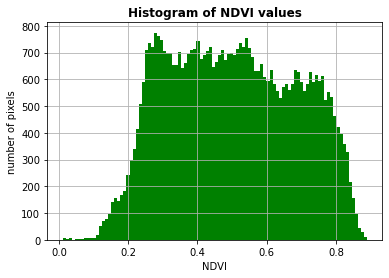

In [26]:
fig, axhist = plt.subplots(1,1)
show_hist(ndvi_aoi, bins=100, masked=False, title='Histogram of NDVI values', facecolor = 'g', ax =axhist)
axhist.set_xlabel('NDVI')
axhist.set_ylabel('number of pixels')
plt.gca().get_legend().remove()

<hr>

<p><img src='./img/all_partners_wekeo_2.png' align='left' alt='Logo EU Copernicus' width='100%'></img></p>